In [1]:
##my stuff
from imagery_psychophysics.src.stirling_maps import sparse_point_maps as spm
from imagery_psychophysics.src.model_z import noise_grid

##other people's stuff
import math
import copy
import numpy as np
import pandas as pd
from PIL.Image import open
from PIL import Image
from scipy.misc import imresize
from os.path import join
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import LinearSegmentedColormap
from scipy.misc import comb as nCk
from time import time
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams
from theano.tensor.shared_randomstreams import RandomStreams
from theano import function, shared
from theano.tensor.extra_ops import repeat, to_one_hot
from matplotlib import pyplot as plt
from matplotlib.mlab import griddata
%matplotlib inline

/home/tnaselar/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)

Couldn't import dot_parser, loading of dot files will not be possible.


## In which we break the code to make it better

Defines a separate class for each variable in the model. Class describes dependencies and parameters, collects relevant theano code, provides sampling and enumeration methods, evaluates conditional prob. dist (assuming dependencies, otherwise evaluates prior).

For starters, we collect all theano expressions required to sample from each variable, then convert to a python function.
In some cases this won't be necessary.


Defines a variational inference function that operates on the classes.





   ### Model variable classes

Utility variables needed for various things below

In [2]:
##a theano random number generator
rng = MRG_RandomStreams(use_cuda = True)

In [3]:
##data types
floatX = 'float32'
intX = 'int32'

In [4]:
##sometime we want to convert to 1hot format outside of theano expressions
##some compile the theano to_one_hot here
_anyVector = T.vector('anyMatrix',dtype=intX)
_anyInt = T.scalar('anyInt',dtype=intX)
to_one_hot_func = function(inputs=[_anyVector,_anyInt], outputs=to_one_hot(_anyVector, _anyInt))

Basic model dimensions

In [5]:
##defines number of objects in an object map
class numObjects(object):
    def __init__(self, largest=10):
        ##npy vars
        self.maxObjs = largest
        ##theano expressions
        self._K = T.scalar('numObjects',dtype='int32') ##a theano integer scalar
        
    def sample(self,M=1):
        return np.random.randint(1,self.maxObjs,size=M)
    
    def set_value(self,value):
        self.K = np.array(value,dtype=intX)

##number of pixels (row, col, total) in an object map
class numPixels(object):
    def __init__(self, largestRows=10,largestCols=10):
        ##npy vars
        self.maxRows = largestRows
        self.maxCols = largestCols

        ##theano expressions
        self._D1 = T.scalar('numPixelRows',dtype='int32') ##num pixel rows
        self._D2 = T.scalar('numPixelCols',dtype='int32') ##num pixel cols
        self._D = self._D1*self._D2 ##total number of pixels
        self._D.name = 'numPixels'
        
    def sample(self,M=1):
        numRows = np.random.randint(1,self.maxRows,size=M) 
        numCols = np.random.randint(1,self.maxCols,size=M)
        numPixels = numRows*numCols
        return numRows,numCols,numPixels
    
    def set_value(self,D1,D2):
        self.D1 = np.array(D1,dtype=intX)
        self.D2 = np.array(D2,dtype=intX)
        self.D = D1*D2

Gamma-distributed hyperparameter for prior distribution over object categories

In [6]:
class priorDispersion(object):
    def __init__(self,maxDispersion=10):
        ##npy vars
        self.maxDispersion = maxDispersion
        ##theano exprs.
        self._dispersion = T.scalar('priorDispersionParam',dtype='float32')  ##dispersion of categorical distribution
        
    def sample(self,M=1):
        return np.random.gamma(self.maxDispersion,size=M)
        
    def set_value(self,value):
        self.dispersion = np.array(value,dtype=floatX)
        
        

The dirichlet-distributed K parameters that define multinomial object distribution prior

In [7]:
class categoryProbs(object):
    def __init__(self, numObjects_inst, priorDispersion_inst):
        self.priorDispersion = priorDispersion_inst
        self.numObjects = numObjects_inst
        self._pi= T.matrix('categoryPrior')  ##1 x K
        
    def sample(self,M=1):
        '''
        sample(M)
        generate M categorical distributions
        each categorical distribution is a (1 x K) draw from a dirichlet
        returns M x K numpy array of draws, each row an independent draw
        '''
        return np.random.dirichlet(np.repeat(self.priorDispersion.dispersion,self.numObjects.K),size=M)
    
    def set_value(self, value):
        self.pi = np.array(value,dtype=floatX)

The object map $Z$

In [8]:
class latentObjMap(object):
    def __init__(self,categoryPrior_inst, numPixels_inst):
        self.categoryPrior=categoryPrior_inst
        self.numPixels = numPixels_inst
        
        ##theano var for a stack of M object maps
        self._Z = T.tensor3('Z', dtype=intX) ##(M x K x D) ##M x K x D stack of one-hot object maps

        self.compile_sampler()
        
    def compile_sampler(self):
        _M = T.scalar('M',dtype='int32') ##number of samples
        _D = self.numPixels._D
        _K = self.categoryPrior.numObjects._K
        _pZ = T.matrix('pZ') ##(K x D) prior
        
        ##this will be an M x K x D int32 tensor
        _sampleZ = rng.multinomial(pvals = repeat(_pZ.T,_M,axis=0)).reshape((_D,_M,_K)).dimshuffle((1,2,0))
        self._Z_sample_func = function([_pZ,_M,_K,_D],outputs=_sampleZ)  
        
    def sample(self, M=1, pZ=None):
        '''
        sample(M=1)
        returns M x K x D numpy array of samples of 1hot encoded object maps.
        each pixel of each map is an i.i.d draw from a categorical prior
        '''
        K = self.categoryPrior.numObjects.K
        D = self.numPixels.D
        if pZ is None:
            catProbs = self.categoryPrior.pi
            pZ = np.repeat(catProbs.T, D, axis=1)
        thisM = np.array(M,dtype=intX)
        return self._Z_sample_func(pZ,thisM,K,D).astype(intX)
    
    def score(self,Z, given_params):
        #so this would be p(Z|pi), i.e. the prior on Z.
        #don't think I need this yet, so I'll pass.
        pass
    
    def view_sample(self, sampleZ, show=True):
        '''
        view_sample(sampleZ, show=True)
        takes a 1 x K x D sample of a 1hot encoded object map 
        and converts it to a D1 x D2 image of the map.
        
        makes plot if show=True
        '''
        sampleZImage = np.argmax(sampleZ,axis=1).reshape((self.numPixels.D1,self.numPixels.D2))
        if show:
            plt.imshow(sampleZImage, interpolation='nearest')
        return sampleZImage
        
    
        

#### The windows

In [9]:
class probes(object):
    def __init__(self, D1, D2, stride = 1, sizes = [1], n_groups=7, group_order = 2):
        ##construct windows W ~ (N x D)
        D = D1*D2
        Windows = []
        for sz in sizes:
            scale_count = 0
            for rows in np.arange(sz,D1,stride,dtype=int, ):
                for cols in np.arange(sz,D2,stride,dtype=int):
                    one_win = np.zeros((D1,D2),dtype=floatX)
                    one_win[(rows-sz):(rows+sz), (cols-sz):(cols+sz)]=1
                    Windows.append(one_win)
                    scale_count +=1
            print scale_count

        
        N = len(Windows)
        n_groups *= D 
        W = np.zeros((N+n_groups,D),dtype=intX)
        for n in range(N):
            W[n,:] = Windows.pop().ravel()

        for n in range(N,N+n_groups):
            rand_pairs = np.random.permutation(N)[:group_order]
            W[n,:] = np.clip(np.sum(W[rand_pairs[0:group_order],:],axis=0), 0, 1)

        W = W[:(N+n_groups),:]


        N = W.shape[0]
        self.windows = W.astype(intX)
        self.D1Prime = D1
        self.D2Prime = D2
        self.DPrime = D

The noise params $\theta_{+}, \theta_{-}$

In [10]:
class noiseParams(object):
    def __init__(self):
        pass
    def enumerate_param_grid(self,theta_dns):
        '''
        enumerate_param_grid(theta_dns)
        inputs:
        theta_dns ~ integer indicating roughly sqrt(G)*2, G = number of grid points
        outputs:
        noise_param ~ 2 x G np array. columns are pairs of noise params, [p_on; p_off]. p_off < p_on for each pair.
        '''
        p_on, p_off = noise_grid(theta_dns,theta_dns)
        return p_on, p_off

The observed responses $\mathbf{r}$

In [11]:
np.arange(1,4)

array([1, 2, 3])

In [12]:
class responses(object):
    '''
    responses(latentObjMap_inst, noiseParams_inst)
    inputs:
        latentObjMap_inst, noiseParams_inst ~ instances of (see above)
    
    outputs:
        construct a responses instance with main attribute "lkhd_cube" that 
        allows to compute likelihood of responses given an object map Z
        
        can set observed responses to known windows using 'set_values'
    '''
    def __init__(self,latentObjMap_inst, noiseParams_inst):
        self.Z = latentObjMap_inst
        self.noise = noiseParams_inst
        
        ##a G x K x K cube of p(r|count,p_on,p_off)
        ##K = max count and/or response, G = number of noise params 
        self.lkhd_cube = T.tensor3('lkhd_cube')  
        
#         self.windows=windows ##N x D', where D' = number of stimulus pixels.
       
        
        
        self._W = T.matrix('windows', dtype=intX)
        self._DPrime = self._W.shape[1]
        
        self.compile_upsampler()
        self.compile_object_counter()
        
    def compile_upsampler(self):
        ##get theano vars for Z and it's dimensions
        _Z = self.Z._Z ##M x K x D stack of one-hot object maps
        _M = _Z.shape[0]
        _K = self.Z.categoryPrior.numObjects._K
        _D1 = self.Z.numPixels._D1
        _D2 = self.Z.numPixels._D2
        _D = self.Z.numPixels._D
        
        ##compute an upscale factor so we can upsample pixels in Z to match W
        _upscale = T.sqrt(self._DPrime // _D).astype(intX)
        
        ##this converts back to image format (M x D1 x D2), where D = D1*D2. int32
        _Z_images = _Z.argmax(axis=1).reshape((_M,_D1,_D2), ndim=3) 

        ##this upsamples the Z-maps to (M x D1' x D2'), where D' = D1'*D2'. still int32
        _Z_upsamples = T.tile(_Z_images.dimshuffle(0,1,2,'x','x'), (_upscale,_upscale)).transpose(0,1,3,2,4).reshape((_M,_D1*_upscale, _D2*_upscale))
        
        ##make a function so we can see upsampled object maps as images (if needed)
        self._Z_usample_image_func = function([_M, _D1, _D2, self._DPrime, _Z], outputs=_Z_upsamples)
        
        ##this converts the Z-maps back to a one-hot encoding (M x K x D'). 
        _Z_upsamples_one_hot = to_one_hot(_Z_upsamples.ravel(), _K,dtype=intX).reshape((_M, self._DPrime, _K)).transpose((0,2,1))
        self._Z_upsample_one_hot_func = function([_M, _K, _D1, _D2, self._DPrime, _Z], outputs=_Z_upsamples_one_hot)
    
    def compile_object_counter(self):

        _Z = self.Z._Z ##M x K x D stack of one-hot object maps
        _W = self._W
       
        ##(M x K x 1 x D')
        ##         N x D'
        ##(M x K x N x D')  sum(D')
        ##(M x K x N)      clip(0,1)
        ##(M x K x N)      sum(K)
        ##(M x N)
        self._object_counts = T.sum(_Z.dimshuffle((0,1,'x',2))*_W,axis=-1).clip(0,1).sum(axis=1)
        self._object_count_func = function([_Z, _W], outputs=self._object_counts)

    
    def compute_feature(self,Z, winIdx=None):
        '''
        compute_feature(Z, winIdx = None)
        the feature in this case is an object count over a map Z given a window W
        
        inputs:
            Z is an MxKxD stack of one-hot encoded object maps
            winIdx ~ array of window indices for getting responses.
                     if supplied, N' = len(winIdx), otherwise N' = total number of windows
        
        output:
            applies N'xD' matrix of windows to map Z, returns MxN' matrix of object counts
            note: if D != D', upsamples Z's so they each have D' pixels
        '''
        M = np.array(Z.shape[0],dtype=intX)
        K = self.Z.categoryPrior.numObjects.K
        D1 = self.Z.numPixels.D1
        D2 = self.Z.numPixels.D2
        D = self.Z.numPixels.D
        if winIdx is not None:
            windows = self.windows[winIdx]
        else:
            windows = self.windows
        if D != self.DPrime:
#             print 'upsampling'
            Z = self._Z_upsample_one_hot_func(M,K,D1,D2,self.DPrime,Z)
            
        return self._object_count_func(Z,windows)
    
    def score(self,r,c,p_on,p_off):
        '''
        calculates p(response | object_count, p_on, p_off), the strange likelihood I derived for this model
        
        score(response,object_count,p_on,p_off)
        inputs:
            response ~ integer
            object_count ~ integer
            p_on,p_off ~ noise params
        outputs:
            scalar likelihood value. 
        '''
        
        ##
        K = self.Z.categoryPrior.numObjects.K
        try:
            counts = np.array([nCk(c,m)*nCk(K-c, r-m) for m in range(min(r,c)+1)])
            probs = np.array([(1-p_on)**(c-m) * (p_on)**m * (p_off)**(r-m) * (1-p_off)**(K-c-r+m) for m in range(min(r,c)+1)])
            return counts.dot(probs)
        except TypeError:
            print 'Error in score. response and count should be integer-valued.'
            print r
            print c
            print min(r,c)
        
        
    
    def make_lkhd_cube(self,p_on, p_off):
        '''
        make_lkhd_cube(p_on,p_off)
        inputs:
            p_on,p_off ~ two array-likes of matching length=G giving pairs of noise params
        outputs:
            lkhd_cube ~ G x (K+1) x K tensor of "scores". dim1 = noise params, dim2 = responses, dim3 = conditioning counts
            The response dimension has size K+1 because subjects can respond 0 through K.
        
        '''
        K = self.Z.categoryPrior.numObjects.K
        countRange = np.arange(1,K+1,dtype=intX)
        respRange = np.arange(0,K+1,dtype=intX)
        G = len(p_on)
        lkhd_cube = np.full((G,K+1,K),0,dtype=floatX)
        for g,p in enumerate(zip(p_on,p_off)):
            for r in respRange:
                for c in countRange:
                    lkhd_cube[g,r,c-1]  = self.score(r,c,p[0],p[1])
        return lkhd_cube

        
    def sample(self,Z,p_on,p_off):
        
        '''
        sample(Z,p_on,p_off)
        inputs:
            Z   ~  M x K x D
            p_on,p_off ~ noise params

        returns
         noisy_object_counts  = M x N matrix of counts drawn i.i.d from likelihood

        this is not part of VI, so this is all done on cpu (no theano)
        '''
        M = Z.shape[0]  ##number of maps to sample
        K = self.Z.categoryPrior.numObjects.K
        object_counts = self.compute_feature(Z)
        N = object_counts.shape[1]
        sample_responses = np.zeros((M,N), dtype = intX)
        for m in range(M):
            for n in range(N):
                resp_dist = np.zeros(K+1)
                oc = np.int(object_counts[m,n])
                for k in range(K+1):
                    resp_dist[k] = self.score(k,oc,p_on,p_off)
                sample_responses[m,n]=np.argmax(np.random.multinomial(1,resp_dist))
        return sample_responses
    
    def set_values(self,data=None, windows=None):
        '''
        set_values(data, windows)
        inputs: supply either or both
            data ~ (1 x N) or (N x 1) or (N,) array of integer responses
            windows ~ instance of "probes" class containing (N x D') array of binary probes, where D' = = number of stimulus pixels.
        outputs:
            sets the observations attribute to data
            sets the windows attributes to windows
        '''
        if data is not None:
            self.observations = np.squeeze(data) ##array of shape (N,)
        if windows is not None:
            self.windows = windows.windows ##N x D', where D' = number of stimulus pixels.
            self.N = self.windows.shape[0]
            self.DPrime = np.array(windows.windows.shape[1],dtype=intX)
            self.D1Prime = windows.D1Prime
            self.D2Prime = windows.D2Prime
            if self.DPrime != self.D1Prime*self.D2Prime:
                raise ValueError('aspect ratio of windows is not right')
        if hasattr(self,'observations') & hasattr(self, 'windows'):
            Nobs = self.observations.shape[0]
            if  Nobs != self.N:
                raise ValueError("number of windows (%d) and data points (%d) don't match" %(self.N, Nobs))

### Inference classes

Define variational updates and optimization procedures for model variables

In [13]:
class inferQZ(object):
    def __init__(self):
        self.compile_updater()
        
    def compile_updater(self):
        ##K x N x K tensor of object count probs
        ##the first K is object id, the last K is object count
        _oc_probs = T.tensor3('oc_probs') 

        ##N x K, this will just be the log of P_star. 
        _lnP_star = T.matrix('lnP_star')

        ## K x 1, this is place holder for the dot product between pixel value and expected log of hyperparameters pi
        _v = T.matrix('prior_penalties')

              ##K x N x K oc_probs
        ##(tensordot)
                  ##N x K lnP_star 
              ##K x 1     lnQ_z
        ##(add V)
              ##K x 1
        ##(exp)
              ##K x 1     Q_z_nn
        ##(normalize)
              ##K x 1     Q_z, the variational posterior element for one pixel

        ##log of Q_z (minus unknown constant that normalizes things)    
        _lnQ_z = T.tensordot(_oc_probs, _lnP_star, [[1,2], [0,1]]).dimshuffle([0,'x'])+_v

        ##non-normalized Q_z. we shift by max value to stabilize upcoming exp
        _Q_z_nn = T.exp(_lnQ_z-T.max(_lnQ_z)) 

        ##variational posterior prob for one pixel
        _Q_z = _Q_z_nn / _Q_z_nn.sum()
        
        self._update_func = function([_oc_probs, _lnP_star, _v], outputs = _Q_z)

In [14]:
class optimizeNoiseParams(object):
    def __init__(self):
        'hi'
        
        
    def update_noiseParams(self, goodnessOfFit):
        '''
        update_noiseParams(goodnessOfFit)
        
        goodnessOfFit ~ G x 1 array of g.o.f. measures, one for each discrete candidate of noise params.
        returns max, argmax of this array
        
        '''
        ##find index of the best lkhd params (scalar integer)
        goodnessOfFitStar = np.max(goodnessOfFit)
        noiseParamStarIdx = np.argmax(goodnessOfFit)
        return goodnessOfFitStar, noiseParamStarIdx

In [15]:
class inferQPi(object):
    def __init__(self,):
        self.compile_updater()
        
    def compile_updater(self):
        _alpha_0 = T.scalar('alpha_0')
        _q_Z = T.matrix('q_Z')  ##K x 1, this is result of summing over pixels in Q_Z matrix. very different from Q_z

        _alpha = _q_Z + _alpha_0 ##broadcasts the scalar _alpha_0 across K

        ##(K x 1) this is needed to update Q_z
        _Eln_pi = T.psi(_alpha) - T.psi(_alpha.sum())

        ##(K x 1) not needed for update of variational posteriors, but we'll want it for model interpretation
        _E_pi = _alpha / _alpha.sum()
        
        ##returns _Eln_pi (K x 1) (object ids x 1)
        ##returns _E_pi (K x 1) (object ids x 1)
        self._update_func = function([_q_Z, _alpha_0], outputs = [_Eln_pi, _E_pi])
 

Variational inference for $q(Z)$, $q(\pi)$, noiseparams

*Nasty book-keeping note*: counts, responses, and object id's are often converted to indices, or to 1hot formats.
To convert counts to indices we need to subtract 1, because counts always range from 1 to K (inclusive),
whereas indices range from 0 to K-1.

To convert object id's to indices we don't need to subtract 1, because id's are coded from 0 to (K-1).

To convert responses to indices we don't need to subtract, because responses range from 0 to K (inclusive).
Becuase 0 to K (inclusive) is K+1 numbers, we do need to make sure that arrays for storing discrete responses have K+1 elements.

Whew.

In [16]:
class VI(object):
    def __init__(self, responses_inst, inferQZ_inst, optimizeNoiseParams_inst, inferQPi_inst):
        self.responses = responses_inst
        self.iQZ = inferQZ_inst
        self.oNP = optimizeNoiseParams_inst
        self.iQPi = inferQPi_inst
        
        ##compile theano expressions, functions
        self.compile_object_probs()
        self.compile_ELBO()
        self.compile_predictive_distribution()
        self.compile_goodness_of_fit()
        
        

    ##===compile theano expressions, functions===
    def compile_object_probs(self):
        _object_counts = self.responses._object_counts ##(M x N)
        _K = self.responses.Z.categoryPrior.numObjects._K
        
        ##non-normalized object count probs (N x K)
        ##we are using these counts as indices, so we have to subtract 1
        _object_count_prob_nn = to_one_hot(_object_counts.astype('int32').flatten()-1,_K).reshape((_object_counts.shape[0],_object_counts.shape[1],_K)).sum(axis=0)

        ##object count probs (N x K)
        _object_count_prob = _object_count_prob_nn / _object_count_prob_nn.sum(axis=1).reshape((_object_count_prob_nn.shape[0], 1))
        
        self.object_count_prob_func = function([_object_counts, _K], outputs = _object_count_prob)
        
    def compile_goodness_of_fit(self):
        _P_theta = T.tensor3('_P_theta') ##(G x N x K)
        _oc_probs = T.matrix('oc_probs') ##N x K ~ this is a place holder for the "object count prob" matrix


        ##(G x N x K)
        ##(    N x K)  (dot product, broadcast across G)
        ##(G x 1)  --> because we don't do vectors we reshape to make output 2Dimensional (G x 1)

        ##log of likelihood

        _ln_P_theta = T.log(_P_theta)

        ##ln [q(theta+, theta-) - const (G x 1) ], the log of the unormalized variational distribution over theta
        ##currently we're taking a point estimate on theta so we don't do the hard normalization step.
        _goodnessOfFit = T.tensordot(_ln_P_theta, _oc_probs, axes=[[1,2], [0,1]],).reshape((_P_theta.shape[0], 1))
        
        ##returns G x 1 goodness of fit array. each element gives goodness of fit for one possible value of noiseparams
        self.goodness_of_fit_func = function([_P_theta, _oc_probs], outputs = _goodnessOfFit)
        
     
    def compile_ELBO(self):
        _goodnessOfFitStar = T.scalar('_goodnessOfFitStar') ##scalar

        _qZ = T.matrix('qZ_holder') ##N x K 

        ##scalar: the entropy of the variational posterior
        a_min = 10e-15
        a_max = 1
        _posterior_entropy = -T.tensordot(_qZ.clip(a_min,a_max), T.log(_qZ.clip(a_min,a_max)))

        ##scalar
        _ELBO = _goodnessOfFitStar  + _posterior_entropy
        self.ELBO_update_func = function([_qZ, _goodnessOfFitStar], outputs=[_goodnessOfFitStar, _posterior_entropy, _ELBO])

    def compile_predictive_distribution(self):
        _lkhdTable = T.matrix('lkhd_table_pred') ##K+1 x K ~ responses x counts, likelihood for fixed noiseparams
        
        ##windows x 1         x counts  |
        ##          responses x counts    tensordot
        ##windows x responses
        _oc_probs = T.matrix('oc_probs') ##N x K ~ this is a place holder for the "object count prob" matrix
        _pred_dist = T.tensordot(_oc_probs, _lkhdTable, axes = [[1],[1]])
        self.predictive_distribution_update_func = function(inputs=[_oc_probs,_lkhdTable], outputs=_pred_dist)
       
        
    ##====initialization methods
    
    def init_number_of_objects_range(self, numOverMax=2):
        
        ##the smallest number of objects has to be max response to any one probe
        smallestPossibleNumberOfObjects = np.max(self.curResponses).astype(intX)
        self.number_of_objects_range = np.arange(smallestPossibleNumberOfObjects, smallestPossibleNumberOfObjects+numOverMax+1)
        
        ##----there's also this complicated thing you could do...
#         maxResponseIdx = np.argmax(self.curResponses)
        
#         ##we'll cover a range from this minimum up to a number determined by probe sizes
#         sizeOfMaxResponseWindow = np.sum(self.responses.windows[self.curIdx[maxResponseIdx], :])
#         sizeOfLargestWindow = np.max(np.sum(self.responses.windows, axis=1))
#         differenceInWindowSizes = sizeOfLargestWindow - sizeOfMaxResponseWindow
        
#         largestNumberOfObjects = np.rint(np.min(smallestPossibleNumberOfObjects + hyperHyper*differenceInWindowSizes, self.hardcodedMaxNumberOfObjects)).astype(intX)
#         self.number_of_objects_range = np.arange(smallestPossibleNumberOfObjects, largestNumberOfObjects)
        
    def init_pixel_resolution_range(self, listOfTuples=None):
        ##don't even trip. trying to preserve aspect ratios...just no.
        if not hasattr(self, 'pixel_resolution_range'):
            if listOfTuples is None:
                raise ValueError('you gotta initialize pixel resolution range by hand. run init_pixel_resoltuion and supply list of shape tuples')
            else:
                self.pixel_resolution_range = listOfTuples                
        else:
            print 'pixel resoltuion range already intialized by hand'
        
        
    
    ##select initial values of noiseparams, discretize, access lkhdCube
    def init_noiseParams(self, pOnInit, pOffInit,noiseParamNumber):
        '''
        init_noiseParams(pOnInit, pOffInit,noiseParamNumber)
        
        create a grid of candidate noise params according noiseParamNumber (i.e., something like square root of number
        of candidates we'll consider)
        
        take initial guess at noise param and return index of nearest candidate in the grid
        
        '''

        ##will need the likelihood cube at whatever resolution we're using to infer noise params, so make here
        self.noiseParamGrid = np.array(self.responses.noise.enumerate_param_grid(noiseParamNumber),dtype=floatX).T
        
        ##for starters, find index of closest noise param values to pOnInit, pOffInit, and then slice the lkhdCube
        noiseParamIdx = np.argmin(map(np.linalg.norm, self.noiseParamGrid-np.array([pOnInit,pOffInit]).T))
        return noiseParamIdx                                      
       
    
    def init_Eln_pi(self, qZ):
        dirichletParameter = self.responses.Z.categoryPrior.priorDispersion.dispersion
        Eln_pi, qPi = self.iQPi._update_func(qZ.sum(axis=1, keepdims=True), dirichletParameter)
        return Eln_pi, qPi
    
    def init_qZ(self, numStarterMaps, empiricalLkhdTableStar, dirichletParameter):
        '''
        qZ, startZ, starerLogs = init_q_Z(numStarterMaps, empiricalLkhdTable, dirichletParameter)
        
        randomly generates a stack of potential latent object maps.
        scores each Z according to p(responses | Z)
        selects Z with highest score = Z*
        constructs an initial qZ by sampling from dirichlet(Z[:,d]*+dirichletParameter) for each pixel d.
        
        inputs:
            numStartermaps ~ number of randomly generated Z's
            empiricalLkhdTable ~ N x K matrix of likelihoods p(response | count, pOn, pOff).
                                 noise params are implicit and assumed to be best guess at start of running vi.
                                 N can be either Ntrn, Ntest, or Nreg
            dirichletParameter ~ slop that you add to best Z to make a qZ
            
        outputs:
            qZ ~ K x D variational posterior
            startZ ~ the best object map from the randomly generated stack
            starterLogs ~ the l
        '''

        ##for generating stacks of one-hot-encoded object maps. these are "special" smooth maps
        def make_object_map_stack(K, num_rows, num_cols, image_dimensions,num_maps):
            size_of_field = int(np.mean(image_dimensions))
            D = np.prod(image_dimensions)
            object_map_base = spm(num_rows,num_cols,size_of_field,cluster_pref = 'random',number_of_clusters = K)
            object_maps = np.zeros((num_maps, K, D),dtype=intX)
            for nm in range(num_maps):
                object_map_base.scatter()
                tmp = np.squeeze(object_map_base.nn_interpolation())
                tmp = imresize(tmp, image_dimensions, interp='nearest')
                ##convert to one_hot encoding
                tmp = np.eye(K)[tmp.ravel()-1].T  ##K x D
                object_maps[nm] = tmp
            return object_maps

        ##generate candidate maps for starting iQ_Z
        K = self.responses.Z.categoryPrior.numObjects.K
        D1 = self.responses.Z.numPixels.D1
        D2 = self.responses.Z.numPixels.D2
        D = D1*D2
        objectMapStack = make_object_map_stack(K, 2*K, 2*K, (D1,D2), numStarterMaps)

        ##get table of log likelihoods for observed data
        logEmpiricalLkhdTable = np.log(empiricalLkhdTableStar)
  
        ##get object_counts ( M x N)
        objectCounts = self.responses.compute_feature(objectMapStack,winIdx=self.curIdx)

        ##get one-hot encoding of object counts (M x N x K)
        ##Use functionalized theano version
        ##we are using these counts as indices, so we have to subtract 1
        oneHotObjectCounts = to_one_hot_func(objectCounts.astype(intX).flatten()-1, K).reshape((objectCounts.shape[0],objectCounts.shape[1],K))
        


        ##evaluate log_likelihoods
        ## one_hot_object_counts = M x N x K
        ##            lkhd_table =     N x K tensordot
        ## observedLogLkhds = M x 1
        starterLogs = np.tensordot(oneHotObjectCounts, logEmpiricalLkhdTable, axes=2)
        bestStartMap = np.argmax(starterLogs)
        startZ = objectMapStack[bestStartMap] ## K x D
        
        qZ = np.zeros((K,D), dtype=floatX)
        for d in range(D): 
            qZ[:,d] = np.random.dirichlet(startZ[:,d]+dirichletParameter)
        return qZ, startZ, starterLogs
   

    ##==========update and optimization methods=============
    
    def optimize_hyper_parameters(self):
        bestPercentCorrect = 0
        bestK = np.inf
        bestD = np.inf
        for model in self.storedModels.values():
            if model.bestPercentCorrect > bestPercentCorrect:
                bestPercentCorrect = model.bestPercentCorrect
                bestModel = model
                bestK = model.responses.Z.categoryPrior.numObjects.K
                bestD = model.responses.Z.numPixels.D
            elif model.bestPercentCorrect == bestPercentCorrect:
                if (model.responses.Z.categoryPrior.numObjects.K < bestK) or (model.responses.Z.numPixels.D < bestD):
                    bestPercentCorrect = model.bestPercentCorrect
                    bestModel = model
                    bestK = model.responses.Z.categoryPrior.numObjects.K
                    bestD = model.responses.Z.numPixels.D
        return bestModel
            
    
    def update_qZ(self, qZ, ExpLnPi, noiseParamStarIdx):
        '''
        coordinate ascent on variational posteriors of object map pixels
        
        update_qZ(qZ, ExpLnPi, noiseParamStarIdx)
        
        '''
        
        ##PStar is our term for the empirical lkhd cube sliced at noiseParamStarIdx. it is N x K
        logPStar = np.log(self.curEmpiricalLkhdCube[noiseParamStarIdx])
        K = self.responses.Z.categoryPrior.numObjects.K
        D = self.responses.Z.numPixels.D
        for d in range(D):
            sampledZ = self.responses.Z.sample(M=self.numSamples, pZ=qZ)
            oc_probs = np.zeros((K, self.curN, K),dtype=floatX)
            v = np.zeros((K,1), dtype=floatX)
            for k in range(K): 
                sampledZ[:,:,d] = 0.    ##clear out object assignment for pixel d
                sampledZ[:,k, d] = 1.   ##assign pixel d to object k
                oc_counts = self.responses.compute_feature(sampledZ,winIdx=self.curIdx)
                oc_probs[k,:,:] = self.object_count_prob_func(oc_counts,K) ##calculate object count probs. given this assignment
                v[k] = np.dot(sampledZ[0,:,d], ExpLnPi,)        ##compare current assignment to prior over assignments
            qZ[:, d] = self.iQZ._update_func(oc_probs, logPStar, v).squeeze() ##update variational posterior for pixel d
        return qZ   

    def update_goodness_of_fit(self, qZ):
        '''
        update_goodness_of_fit(qZ)
        
        return G x 1 array of measures of how well the variational posterior qZ matches the data
        for each of the G possible values of the noise params.
        
        '''
        empiricalLkhdCube = self.curEmpiricalLkhdCube
        K = self.responses.Z.categoryPrior.numObjects.K
        
        sampledZ = self.responses.Z.sample(M=self.numSamples, pZ=qZ)
        oc_counts = self.responses.compute_feature(sampledZ,winIdx=self.curIdx)
        oc_probs = self.object_count_prob_func(oc_counts, K)
        
        goodnessOfFit = self.goodness_of_fit_func(empiricalLkhdCube, oc_probs)
        
        return goodnessOfFit
            
                                    
    def optimize_PStar(self,qZ):
        '''
        optimize_PStar(qZ)
        
        PStar is what we call the empirical lkhd cube sliced at the current best noise params.
        So, it is our current guess at the empricial lkhd table.
        
        We find the best noise param (by measuring goodness of fit)
        '''
        goodnessOfFit = self.update_goodness_of_fit(qZ)
        goodnessOfFitStar, noiseParamStarIdx = self.oNP.update_noiseParams(goodnessOfFit)

        ##N x K 
        PStar = self.curEmpiricalLkhdCube[noiseParamStarIdx]
        
        #1 x 2 best noiseparams
        noiseParamStar = self.noiseParamGrid[noiseParamStarIdx,:]
        return noiseParamStar, noiseParamStarIdx, PStar, goodnessOfFitStar
    
    def update_qPi(self, qZ):
        ##update prior params
        dirchletParam=self.responses.Z.categoryPrior.priorDispersion.dispersion
        ExpLnPi, qPi = self.iQPi._update_func(qZ.sum(axis=1, keepdims=True),dirchletParam)
        return ExpLnPi, qPi
    

        
    ##===criticism===        
    def update_ELBO(self, qZ, goodnessOfFitStar):
        goodnessOfFitStar, posterior_entropy, ELBO = self.ELBO_update_func(qZ,np.asscalar(goodnessOfFitStar))
        return goodnessOfFitStar, posterior_entropy, ELBO
        
    def update_log_predictive_distribution(self, qZ, noiseParamStarIdx):
        '''
        update_log_predictive_distribution(qZ, noiseParamStarIdx)
        inputs:
            qZ ~ K x D
            noiseParamStarIDx ~ int
        
        outputs:
            predictiveDistribution ~ N x K+1 distribution over the K+1 possible response to each of the N windows
            empiricalLogPredictiveDistribution ~ N x 1, this is log of predictiveDistribution sliced at empirical responses 
        '''
        ##create object count probabilities
        K = self.responses.Z.categoryPrior.numObjects.K       
        sampledZ = self.responses.Z.sample(M=self.numSamples, pZ=qZ)
        oc_counts = self.responses.compute_feature(sampledZ,winIdx=self.curIdx)
        oc_probs = self.object_count_prob_func(oc_counts, K)
        
        ##N x K+1, a distribution over K+1 responses to each window
        predictiveDistribution = self.predictive_distribution_update_func(oc_probs,self.lkhdCube[noiseParamStarIdx])
        
        ##slice the predictive  distribution at the actual responses
        ##note that responses can be used as indices without change (unlike counts)
        responsesAsIndices = self.curResponses.astype(intX)
        empiricalPredictiveDistribution = predictiveDistribution[range(self.curN), responsesAsIndices] ##(N x 1)
        
        ##N x 1
        logEmpiricalPredictiveDistribution = np.log(empiricalPredictiveDistribution)
        return predictiveDistribution, logEmpiricalPredictiveDistribution    
    
    
    def update_percent_correct(self, predictiveDistribution):
        
        responses = self.curResponses.astype(intX)
        predictions = np.argmax(predictiveDistribution, axis=1)
        fraction_correct = np.sum(responses==predictions) / (self.curN*1.)
        return fraction_correct*100, predictions
    
    def criticize(self, qZ, noiseParamStarIdx, goodnessOfFitStar, t):
        
        self.goodnessOfFitStar_history[t] = goodnessOfFitStar
        _,self.posteriorEntropy_history[t], self.ELBO_history[t] = self.update_ELBO(qZ, goodnessOfFitStar)
        
        ##get predictive distribution
        predictiveDistribution,logEmpiricalPredictiveDistribution = self.update_log_predictive_distribution(qZ, noiseParamStarIdx)
        
        ##sum to get probability of observed data under predictive distribution
        self.lnPredictiveDistribution_history[t] = logEmpiricalPredictiveDistribution.mean()
        
        ##use predicitive distribution to calculate percent correct
        self.percentCorrect_history[t],_ = self.update_percent_correct(predictiveDistribution)
        
        if self.percentCorrect_history[t] > self.bestPercentCorrect:
            print '!new best!'
            self.bestQZ = qZ.copy()
            self.bestNoiseParam = self.noiseParamGrid[noiseParamStarIdx,:].copy()
            self.bestPercentCorrect = self.percentCorrect_history[t]
            self.bestlnPredictiveDistribution = self.lnPredictiveDistribution_history[t]
        

        print 'ELBO: %f' %(self.ELBO_history[t])
        print 'goodness of fit: %f' %(goodnessOfFitStar)
        print 'posterior_entropy: %f' %(self.posteriorEntropy_history[t])
        print 'mean log of predictive distribution over test samples: %f' %(self.lnPredictiveDistribution_history[t])
        print 'pecent correct over test samples: %f' %(self.percentCorrect_history[t])
        print '\n'
        
        return 
    
        
    ##======utilities and bookeeping
    def rng_seed(self):
        if not hasattr(self, 'randNumberSeed'):
            self.randNumberSeed = np.random.randint(0,high=10**4)
        np.random.seed(self.randNumberSeed)
    
    def train_test_regularize_splits(self, trainTestSplit, trainRegSplit):
        N = self.responses.observations.shape[0]
        shuffledIdx = np.random.permutation(N)
        lastTestIdx = np.floor((1-trainTestSplit)*N)
        lastRegIdx = lastTestIdx+np.floor((1-trainRegSplit)*(N-lastTestIdx))
    
        testIdx = shuffledIdx[:lastTestIdx]
        regIdx = shuffledIdx[lastTestIdx:lastRegIdx]
        trainIdx = shuffledIdx[lastRegIdx:]
        return trainIdx, testIdx, regIdx
    
    def empirical_lkhd_cube(self, idx=None):
        if idx is None:
            respAsIdx = self.responses.observations.astype(intX)
        else:
            respAsIdx = self.responses.observations[idx].astype(intX)    
        return np.squeeze(self.lkhdCube[:,respAsIdx,:])
        
    def update_current(self, idx):
        self.curN = len(idx)
        self.curIdx = idx
        self.curIdx = self.curIdx
        self.curResponses = self.responses.observations[self.curIdx]
        try: ##because the computation graph is inelegant
            self.curEmpiricalLkhdCube = self.empirical_lkhd_cube(idx=self.curIdx)
        except:
            pass
        
        
    def store_learned_model(self):
        if not hasattr(self, 'storedModels'):
            self.storedModels = {0:copy.deepcopy(self)}
            
        else:
            newModelKey = np.max(self.storedModels.keys())+1
            self.storedModels[newModelKey] = copy.copy(self)
            del self.storedModels[newModelKey].storedModels
        
    ##visualize the variational posterior over pixels
    def see_Q_Z(self, qZ, target_object_map = None, clim=[0,1]):
        ##view: construct an image grid
        fig = plt.figure(1, (30,10))
        K = qZ.shape[0]
        D1 = self.responses.Z.numPixels.D1
        D2 = self.responses.Z.numPixels.D2

        ##
        qZAsImageStack = qZ.reshape(K,D1,D2)
        if target_object_map is not None:
            K += 1
        grid = ImageGrid(fig, 111, # similar to subplot(111)
                        nrows_ncols = (1, K), # creates grid of axes
                        axes_pad=0.5, # pad between axes in inch.
                        cbar_mode = 'each',
                        cbar_pad = .05
                        )
        if target_object_map is not None:
            im = grid[0].imshow(target_object_map,cmap='Dark2', interpolation = 'nearest')
            grid[0].cax.colorbar(im)
            for kk in range(1,K):
                im = grid[kk].imshow(qZAsImageStack[kk-1], cmap='hot', clim=clim)
                grid[kk].cax.colorbar(im)

        else: 
            for kk in range(0,K):
                im = grid[kk].imshow(qZAsImageStack[kk], cmap='hot', clim=clim)
                grid[kk].cax.colorbar(im)    
    
    ##=============RUN the actual variational inference algorithm========
    
    ##Note: the only arguments passed to the various methods should be those that are updated every iteration.
    def run_VI(self, initialNoisinessOfZ, pOnInit, pOffInit, noiseParamNumber, numStarterMaps, numSamples, maxIterations, trainTestSplit, trainRegSplit, optimizeHyperParams=True):
      
        
        ##reset the rng seed
        self.rng_seed()

        ##divide the training, testing, regularization datasets
        trainIdx, testIdx, regIdx = self.train_test_regularize_splits(trainTestSplit=trainTestSplit, trainRegSplit=trainRegSplit)

        ##set empirical likelihoods, and responses to training set
        self.update_current(trainIdx)
        
        
        if optimizeHyperParams:
            ##collect the arguments for use in recursive call below
            allArgs = [initialNoisinessOfZ, pOnInit, pOffInit, noiseParamNumber, numStarterMaps, numSamples, maxIterations, trainTestSplit, trainRegSplit]
            
            ##initialize the ranges of hyperparameters
            self.init_number_of_objects_range()
            self.init_pixel_resolution_range()
            
            ##run vi in a loop over hyperparameters
            for k in self.number_of_objects_range:
                self.responses.Z.categoryPrior.numObjects.set_value(k)
                print '--------number of objects: %d------------' %(self.responses.Z.categoryPrior.numObjects.K)
                for d1,d2 in self.pixel_resolution_range:
                    self.responses.Z.numPixels.set_value(d1,d2)
                    print '--------image resolution: (%d,%d,%d)------------' %(self.responses.Z.numPixels.D1,self.responses.Z.numPixels.D2,self.responses.Z.numPixels.D)
                    ##recursively call run_VI, avoiding the hyperparameter loop
                    numIters=self.run_VI(*allArgs, optimizeHyperParams=False)
                    self.numIters = numIters
                    self.store_learned_model()
            bestModel = self.optimize_hyper_parameters()
            bestModel.trainIdx = trainIdx
            bestModel.regIdx = regIdx
            bestModel.testIdx = testIdx
            return bestModel
        else:


            ##--construct the lkhdCube and slice it at the discrete value of the noise params closest to the supplied init values
            noiseParamStarIdx = self.init_noiseParams(pOnInit, pOffInit, noiseParamNumber)

            ##store numSamples for consultation in a few functions
            self.numSamples = numSamples

            ##--construct lkhd cube
            self.lkhdCube = self.responses.make_lkhd_cube(self.noiseParamGrid[:,0],self.noiseParamGrid[:,1])  ##G x K x K

            ##set current empirical likelihoods, and responses to training set (have to re-run because of lkhdCube)
            self.update_current(trainIdx)

            ##initialize variational posterior
            qZ, self.startZ, self.starterLogs = self.init_qZ(numStarterMaps, self.curEmpiricalLkhdCube[noiseParamStarIdx], initialNoisinessOfZ)

            ##initialize variational prior
            ExpLnPi,_ = self.init_Eln_pi(qZ)

            ##get initial goodnessOfFitStar
            goodnessOfFitStar = self.update_goodness_of_fit(qZ)[noiseParamStarIdx]

            ##set initial PStar, which is our term for an empirical lkhd table evaluated at the noiseParamStarIdx
            ##PStar ~ N x K
            PStar = self.curEmpiricalLkhdCube[noiseParamStarIdx]

            ##--initialize arrays for learning histories and storing solutions
            iteration = 0
            self.ELBO_history = np.zeros((maxIterations+1,1))
            self.goodnessOfFitStar_history = np.zeros((maxIterations+1,1))
            self.posteriorEntropy_history = np.zeros((maxIterations+1,1))
            self.percentCorrect_history = np.zeros((maxIterations+1,1))
            self.lnPredictiveDistribution_history = np.zeros((maxIterations+1,1))
            self.bestPercentCorrect = 0

            delta_ELBO = np.inf
            min_delta_ELBO = 10e-15
            ELBO_old = 0.

            ##--publish initial criticism. use regularization data
            self.update_current(regIdx)
            self.criticize(qZ, noiseParamStarIdx, goodnessOfFitStar, iteration)

            ##switch back to training data
            self.update_current(trainIdx)

            iteration += 1


            while (delta_ELBO > min_delta_ELBO) and (iteration <= maxIterations):

                ##put lkhd in log domain
                lnPStar = np.log(PStar).astype(floatX)

                ##coordinate ascent on variational posteriors of object map pixels
                qZ = self.update_qZ(qZ, ExpLnPi, noiseParamStarIdx)


                ##update noise params: calculates goodness of fit for all possible noise params, finds best,
                ##returns it, returns best noiseParam, index of best noiseParam, and updates PStar
                noiseParamStar, noiseParamStarIdx, PStar, goodnessOfFitStar = self.optimize_PStar(qZ)

                ##update prior params
                ExpLnPi, _ = self.update_qPi(qZ)

                ##criticize using regularization data
                self.update_current(regIdx)
                self.criticize(qZ, noiseParamStarIdx, goodnessOfFitStar, iteration)

                ##switch back to training data
                self.update_current(trainIdx)

                ##update ELBO convergence criteria
                delta_ELBO = np.abs(self.ELBO_history[iteration]-ELBO_old)
                ELBO_old = self.ELBO_history[iteration]

                iteration += 1

            return iteration


## Create data, test code

### Construct model variables

In [17]:
##model variable parameters
K = 3
D1,D2 = 4,6
dispersion = 2.2

##number of objects
nObj = numObjects()
nObj.set_value(K)

##dispersion on category prior
pDisp = priorDispersion()
pDisp.set_value(dispersion)


##resolution of object map Z
nPixels = numPixels()
nPixels.set_value(D1,D2)

##category prior and object map
catProb = categoryProbs(nObj,pDisp)
catProb.set_value(catProb.sample())
Z = latentObjMap(catProb,nPixels)
originalZ = copy.deepcopy(Z)

##create a sample of an object map
targetZ = Z.sample(M=1)

##noise params
nP = noiseParams()

##windows
DPrime1 = 8*D1
DPrime2 = 8*D2
w = probes(DPrime1,DPrime2, stride=3, sizes=[1], group_order = 2, n_groups=1)

##response object
r = responses(Z,nP)

##fake data
r.set_values(windows=w)
data = r.sample(targetZ,0.8,.1)
r.set_values(data=data)

print 'total observations: %d' %(r.N)

176
total observations: 1712


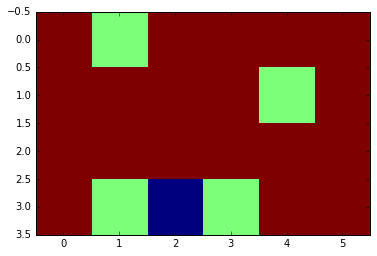

In [18]:
_=Z.view_sample(targetZ,show=True)

total observations: 


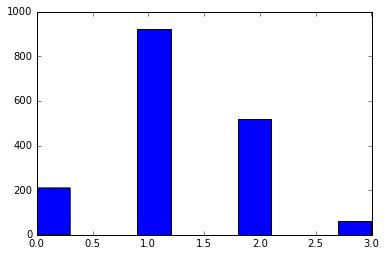

In [19]:
_= plt.hist(r.observations.T)
print 'total observations: '

### Define classes for the inferences we'll perform ($q(Z), q(\pi)$) and the optimizations (noise params).

In [20]:
##these are the variational inferences we want to perform
iqZ = inferQZ()
iqPi = inferQPi()

##this is the parameter optimization (point-estimate) we want
noiseParamGridDensity = 10
oNP = optimizeNoiseParams()

##variational inference combines them all together
vi = VI(r, iqZ,oNP, iqPi)

### Run variational inference

In [21]:
##inference algorithm parameters
initialNoisinessOfZ = 0.2
pOn_init, pOff_init = .9, 0.1
densityOfNoiseParamGrid = 25
numStarterMaps = 10**2
numSamplesForComputingObjectCountProbs = 10
maxNumIterations = 10
trainTestSplit = .99
trainRegSplit = .8

##set the pixel resolution hyperparameter range by hand
vi.init_pixel_resolution_range(listOfTuples= [(4,6), (8,12)])

In [22]:
bestModel = vi.run_VI(initialNoisinessOfZ, \
                     pOn_init, pOff_init, \
                     densityOfNoiseParamGrid, \
                     numStarterMaps, \
                     numSamplesForComputingObjectCountProbs, \
                     maxNumIterations, \
                     trainTestSplit, trainRegSplit, \
                     optimizeHyperParams=True)
                     
                    

pixel resoltuion range already intialized by hand
--------number of objects: 3------------
--------image resolution: (4,6,24)------------
!new best!
ELBO: -2178.311768
goodness of fit: -2186.766357
posterior_entropy: 8.454625
mean log of predictive distribution over test samples: -1.434616
pecent correct over test samples: 42.011834


!new best!
ELBO: -1234.164429
goodness of fit: -1234.203247
posterior_entropy: 0.038761
mean log of predictive distribution over test samples: -0.897171
pecent correct over test samples: 65.976331


ELBO: -1234.203247
goodness of fit: -1234.203247
posterior_entropy: 0.000004
mean log of predictive distribution over test samples: -0.897171
pecent correct over test samples: 65.976331


ELBO: -1234.203247
goodness of fit: -1234.203247
posterior_entropy: 0.000004
mean log of predictive distribution over test samples: -0.897171
pecent correct over test samples: 65.976331


--------image resolution: (8,12,96)------------
!new best!
ELBO: -2454.467773
goodness o

/home/tnaselar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:382: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/tnaselar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:383: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/tnaselar/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:384: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/musc.repo/Docs/tnaselar/code/Python/imagery_psychophysics/src/model_z.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  p_on =  [np.array([ii]*np.max([np.ceil(D*ii),1])) for ii in np.linspace(small,1-small,dns)]


In [23]:
print bestModel.responses.Z.numPixels.D1
print bestModel.responses.Z.numPixels.D2
print bestModel.responses.Z.categoryPrior.numObjects.K

4
6
3


In [24]:
bestModel.bestNoiseParam

array([ 0.79108334,  0.08406141], dtype=float32)

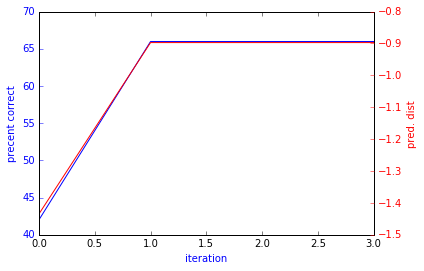

In [25]:
fig, ax = plt.subplots()
ax.plot(bestModel.percentCorrect_history[:bestModel.numIters])
ax.set_xlabel('iteration', color='b')
ax.set_ylabel('precent correct', color='b')
ax.tick_params('y', colors='b')


ax2 = ax.twinx()
ax2.plot(bestModel.lnPredictiveDistribution_history[:bestModel.numIters], 'r')
ax2.set_ylabel('pred. dist', color='r')
ax2.tick_params('y', colors='r')

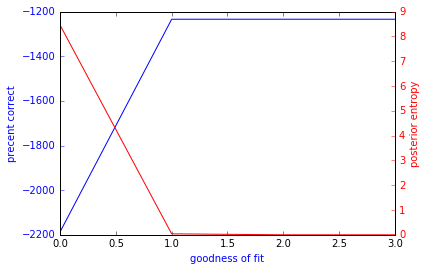

In [26]:
fig, ax = plt.subplots()
ax.plot(bestModel.goodnessOfFitStar_history[:bestModel.numIters])
ax.set_xlabel('goodness of fit', color='b')
ax.set_ylabel('precent correct', color='b')
ax.tick_params('y', colors='b')


ax2 = ax.twinx()
ax2.plot(bestModel.posteriorEntropy_history[:bestModel.numIters], 'r')
ax2.set_ylabel('posterior entropy', color='r')
ax2.tick_params('y', colors='r')

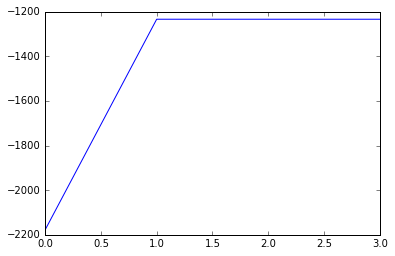

In [27]:
plt.plot(bestModel.ELBO_history[:bestModel.numIters])

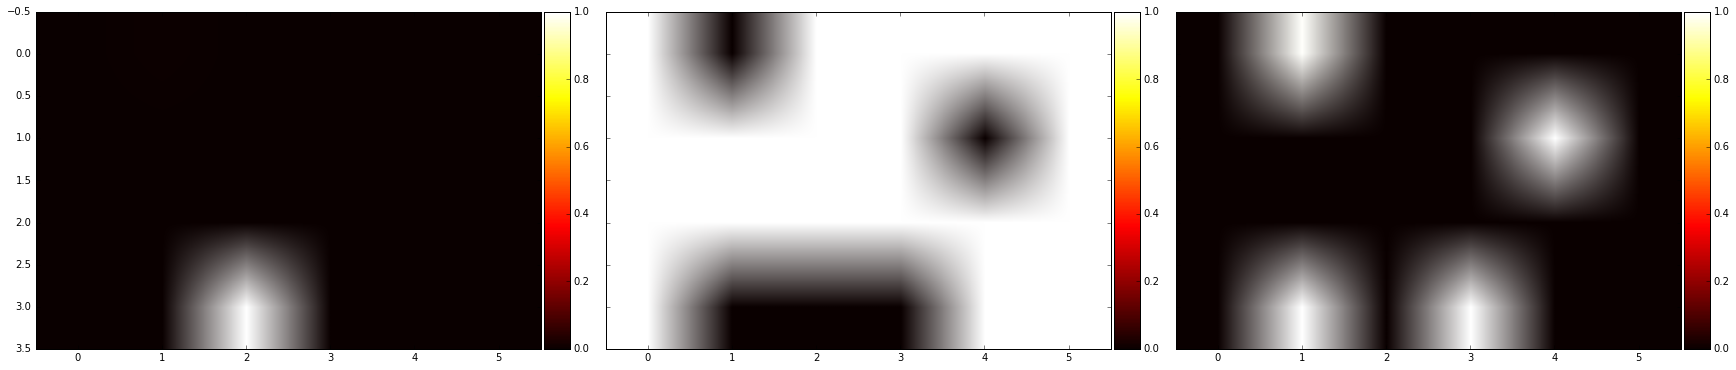

In [28]:
bestModel.see_Q_Z(bestModel.bestQZ)

In [29]:
bestModel.responses.Z.categoryPrior.numObjects.K

array(3, dtype=int32)

In [30]:
bestModel.bestQZ.shape

(3, 24)

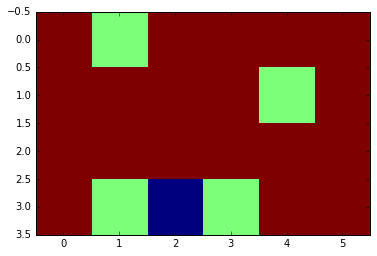

In [31]:
_=originalZ.view_sample(targetZ,show=True)

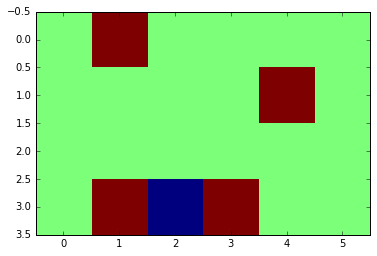

In [32]:
sampZ = bestModel.responses.Z.sample(M=1,pZ=bestModel.bestQZ)
_=bestModel.responses.Z.view_sample(sampZ)

In [34]:
bestModel.responses.windows.shape

(1712, 1536)

In [33]:
def see_posterior_overlay(Q_Z, Z, image_dimensions):
    '''
    Q_Z ~ K x D
      Z ~ K x D
    '''
    ##view: construct an image grid
    fig = plt.figure(1, (40,20))
    K = Q_Z.shape[0]
    grid = ImageGrid(fig, 111, # similar to subplot(111)
                    nrows_ncols = (1, K), # creates grid of axes
                    axes_pad=0.5, # pad between axes in inch.
                    cbar_mode = 'each',
                    cbar_pad = .05
                    )
    
    colors = [(0, 0, 0), (1., 1., 0)]
    cm_1 = LinearSegmentedColormap.from_list(
        'object_map', colors, N=2)

    colors = [(0, 0, 0), (0., 0., 1.)]
    cm_2 = LinearSegmentedColormap.from_list(
        'prob', colors, N=20)

    
    log_prob = object_confusion(Q_Z, Z)
    Q_Z = Q_Z.reshape((K, image_dimensions[0],image_dimensions[1]))
    Z = Z.reshape((K, image_dimensions[0], image_dimensions[1]))
    for k in range(K):
        
        max_k,max_j = np.unravel_index(np.argmax(log_prob), log_prob.shape)
        log_prob[max_k,:] = -np.inf
        log_prob[:,max_j] = -np.inf
        grid[k].imshow(Z[max_j],cmap=cm_1)
        grid[k].imshow(Q_Z[max_k], cmap=cm_2, clim=[0,1], alpha = 0.6)
        
    
    
    
            